## Optimizing Training Pipeline in Pytorch

To improve training performance in any deep learning pipeline, pytorch suggests few extra additions of codes in exitin pipeline.
These additions are explained and mentioned well here in [Performance Tuning Guide](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html) . In this notebook you will encounter few of such features with hands-on dedicated for GPU Computing.

In [1]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

### Set GPU Device if multiple

In [3]:
!nvidia-smi

Wed Feb 16 10:22:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   27C    P8     8W / 250W |   4113MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 51%   

In [5]:
##############################################################
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="4"
##############################################################

### Use device for `cuda` or `cpu` based on availability

In [6]:
####################################################################
#GPU using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
####################################################################

device(type='cuda')

In [7]:
config = dict(
    IMAGE_PATH= "nih-dataset/nih-15-class",
    saved_path="saved/resnet18.pt",
    lr=0.001, 
    EPOCHS = 5,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 224,
    TRAIN_VALID_SPLIT = 0.2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=2,
    USE_AMP = True,
    channels_last=False)
####################################################################

In [8]:
# For custom operators, you might need to set python seed
random.seed(config['SEED'])
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG 
np.random.seed(config['SEED'])
# Prevent RNG for CPU and GPU using torch
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])

### Create tensors directly on the target device

Instead of calling `torch.rand(size).cuda()` to generate a random tensor, produce the output directly on the target device: `torch.rand(size, device=torch.device('cuda'))`.

This is applicable to all functions which create new tensors and accept device argument: `torch.rand(), torch.zeros(), torch.full()` and similar.

CUDA Convolution Benchmarking: Best Convolution Algo but may loose reproducibility if True

In [9]:
# If researcher and wants to reproducuce: False
# If developer wants performance: True
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

Apply Data Transforms (Aumentations + Processing)

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [13]:
my_path = '../../../dataset/VINBIG_DATA/vinbig_2class_version2'
sorted(os.listdir(my_path))

['abnormal', 'normal']

In [15]:
import torchvision
test_data = torchvision.datasets.ImageFolder(root=my_path,transform=data_transforms['test'])
print(len(images))

9036


In [16]:
images.class_to_idx

{'abnormal': 0, 'normal': 1}

In [17]:
# train_dl = torch.utils.data.DataLoader(dataset=train_data,batch_size=32,shuffle=True, num_workers = config['num_workers'],
#                                           pin_memory = config['pin_memory'])
# valid_dl = torch.utils.data.DataLoader(dataset = valid_data,batch_size=32,shuffle=True, num_workers = config['num_workers'],
#                                           pin_memory = config['pin_memory'])
test_dl = torch.utils.data.DataLoader(dataset=test_data,batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])

Optimizers:
Gradient Descent:-
    a. Stoicastic Gradient Descent bs = 1; 'n' number of examples. 'n / 1' number of data loader/steps for 1 Epoch
    b. Mini-Batch Gradient Descent bs = 32; 'n' number of examples. 'n / 32' number of dataloaders/step for 1 Epoch 
    c. Full Batch Gradient Descent bs = total_number_of_samples number of dataloader/steps = 1 for 1 Epoch

tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0])


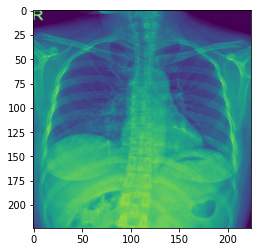

In [18]:
import matplotlib.pyplot as plt
a = iter(test_dl)
b = next(a)
print(b[1])
plt.imshow(b[0][0][0])

In [19]:
criterion = nn.CrossEntropyLoss()

Load Model : Pretrained from torchvision model zoo or Saved model

In [20]:
efficientnet = models.efficientnet_b4(pretrained = True)
efficientnet.classifier[1] = nn.Linear(in_features = 1792, out_features = 2, bias = True)
model = efficientnet

In [21]:
model.load_state_dict(torch.load('saved/efficientnet_b4.pt'))

<All keys matched successfully>

In [22]:
#Channel Last Optimization in Model

model = model.to(config['device'])

In [23]:
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
# Loss Function

### Efficientnet

In [24]:
model.eval()
running_loss = 0.0
running_corrects = 0
total = 0
preds = []
pred_labels = []
labels = []

        # Disable gradient calculation for validation or inference using torch.no_rad()
with torch.no_grad():
            for x,y in test_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                predict_prob = F.softmax(valid_logits)
                _,predictions = predict_prob.max(1)
                predictions = predictions.to('cpu')
                
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
                predict_prob = predict_prob.to('cpu')
                
                pred_labels.extend(list(predictions.numpy()))
                preds.extend(list(predict_prob.numpy()))
                y = y.to('cpu')
                labels.extend(list(y.numpy()))
            
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
print("Test Loss is {}".format(epoch_loss))
print("Test Accuracy is {}".format(epoch_acc.cpu()))

Test Loss is 1.51047656798901
Test Accuracy is 0.6622399291722001


In [25]:
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

(0.635850991114149, 0.8015941404566997, 0.7091671431294073, None)

In [26]:
#y_pred = np.transpose([pred[:, 1] for pred in preds])
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.7359618948874116

In [27]:
pred_effb4 = np.array(preds)
y_test_effb4 = np.array(labels)

## Mobilenet v2

In [28]:
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(in_features = 1280, out_features = 2, bias = True)
model = mobilenet
model.load_state_dict(torch.load('saved/mobilenetv2.pt'))
model = model.to(config['device'])

In [29]:
model.eval()
running_loss = 0.0
running_corrects = 0
total = 0
preds = []
pred_labels = []
labels = []

        # Disable gradient calculation for validation or inference using torch.no_rad()
with torch.no_grad():
            for x,y in test_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                predict_prob = F.softmax(valid_logits)
                _,predictions = predict_prob.max(1)
                predictions = predictions.to('cpu')
                
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
                predict_prob = predict_prob.to('cpu')
                
                pred_labels.extend(list(predictions.numpy()))
                preds.extend(list(predict_prob.numpy()))
                y = y.to('cpu')
                labels.extend(list(y.numpy()))
            
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
print("Test Loss is {}".format(epoch_loss))
print("Test Accuracy is {}".format(epoch_acc.cpu()))

Test Loss is 1.294436972428339
Test Accuracy is 0.5796812749003984


In [30]:
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

(0.5594868903298562, 0.8550193881947437, 0.6763803680981595, None)

In [31]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.6441569591685973

In [32]:
pred_mobv2 = np.array(preds)
y_test_mobv2 = np.array(labels)

## Mobilenet v3

In [33]:
mobilenet = models.mobilenet_v3_small(pretrained=True)
mobilenet.classifier[3] = nn.Linear(in_features = 1024, out_features = 2, bias = True)
model = mobilenet
model.load_state_dict(torch.load('saved/mobilenetv3.pt'))

<All keys matched successfully>

In [34]:
model = model.to(config['device'])

In [35]:
model.eval()
running_loss = 0.0
running_corrects = 0
total = 0
preds = []
pred_labels = []
labels = []

        # Disable gradient calculation for validation or inference using torch.no_rad()
with torch.no_grad():
            for x,y in test_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                predict_prob = F.softmax(valid_logits)
                _,predictions = predict_prob.max(1)
                predictions = predictions.to('cpu')
                
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
                predict_prob = predict_prob.to('cpu')
                
                pred_labels.extend(list(predictions.numpy()))
                preds.extend(list(predict_prob.numpy()))
                y = y.to('cpu')
                labels.extend(list(y.numpy()))
            
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
print("Test Loss is {}".format(epoch_loss))
print("Test Accuracy is {}".format(epoch_acc.cpu()))

Test Loss is 1.2675942241644216
Test Accuracy is 0.5745905267817618


In [36]:
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

(0.5693671766342142, 0.7055148642826368, 0.6301712526457571, None)

In [37]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.5952738860735439

In [38]:
pred_mobv3 = np.array(preds)
y_test_mobv3 = np.array(labels)

## ExLNet

In [39]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)

squeezenet.features[3].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[3].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[4].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[4].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[5].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[5].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[7].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[7].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[8].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[8].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[9].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[9].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[10].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[10].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.features[12].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[12].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.classifier = nn.Sequential(
                                        nn.Dropout(0.5),
                                        nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1)),
                                        nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

model = squeezenet


In [54]:
model.load_state_dict(torch.load('saved/exlnet01.pt'))
model = model.to(config['device'])

In [55]:
model.eval()
running_loss = 0.0
running_corrects = 0
total = 0
preds = []
pred_labels = []
labels = []

        # Disable gradient calculation for validation or inference using torch.no_rad()
with torch.no_grad():
            for x,y in test_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                predict_prob = F.softmax(valid_logits)
                _,predictions = predict_prob.max(1)
                predictions = predictions.to('cpu')
                
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
                predict_prob = predict_prob.to('cpu')
                
                pred_labels.extend(list(predictions.numpy()))
                preds.extend(list(predict_prob.numpy()))
                y = y.to('cpu')
                labels.extend(list(y.numpy()))
            
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
print("Test Loss is {}".format(epoch_loss))
print("Test Accuracy is {}".format(epoch_acc.cpu()))

Test Loss is 0.6601347727235201
Test Accuracy is 0.5868747233289066


In [56]:
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

(0.5648451990298188, 0.8528651443343387, 0.6795983177409665, None)

In [57]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.6590064846956515

In [58]:
pred_exlnet = np.array(preds)
y_test_exlnet = np.array(labels)

## Shufflenet

In [59]:
shufflenet = models.shufflenet_v2_x1_0(pretrained = True)
shufflenet.fc = nn.Linear(in_features = 1024, out_features = 2, bias=True)
model = shufflenet

In [60]:
model.load_state_dict(torch.load('saved/shufflenetv1.pth'))
model = model.to(config['device'])

In [61]:
model.eval()
running_loss = 0.0
running_corrects = 0
total = 0
preds = []
pred_labels = []
labels = []

        # Disable gradient calculation for validation or inference using torch.no_rad()
with torch.no_grad():
            for x,y in test_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                predict_prob = F.softmax(valid_logits)
                _,predictions = predict_prob.max(1)
                predictions = predictions.to('cpu')
                
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
                predict_prob = predict_prob.to('cpu')
                
                pred_labels.extend(list(predictions.numpy()))
                preds.extend(list(predict_prob.numpy()))
                y = y.to('cpu')
                labels.extend(list(y.numpy()))
            
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
print("Test Loss is {}".format(epoch_loss))
print("Test Accuracy is {}".format(epoch_acc.cpu()))

Test Loss is 1.048439786675864
Test Accuracy is 0.629924745462594


In [62]:
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

(0.6291285316354954, 0.6811719086600603, 0.6541166735622672, None)

In [63]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.6867918916104507

In [64]:
pred_shuff = np.array(preds)
y_test_shuff = np.array(labels)

## ResNet50

In [65]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features = 2048, out_features = 2, bias = True))
model = resnet50

model.load_state_dict(torch.load('saved/resnet50.pt'))
model = model.to(config['device'])

In [66]:
model.eval()
running_loss = 0.0
running_corrects = 0
total = 0
preds = []
pred_labels = []
labels = []

        # Disable gradient calculation for validation or inference using torch.no_rad()
with torch.no_grad():
            for x,y in test_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                predict_prob = F.softmax(valid_logits)
                _,predictions = predict_prob.max(1)
                predictions = predictions.to('cpu')
                
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
                predict_prob = predict_prob.to('cpu')
                
                pred_labels.extend(list(predictions.numpy()))
                preds.extend(list(predict_prob.numpy()))
                y = y.to('cpu')
                labels.extend(list(y.numpy()))
            
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
print("Test Loss is {}".format(epoch_loss))
print("Test Accuracy is {}".format(epoch_acc.cpu()))

Test Loss is 1.7651270686287224
Test Accuracy is 0.5716024789729969


In [67]:
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

(0.5569339831634914, 0.8123653597587247, 0.6608253745728555, None)

In [68]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.6149591840896981

In [69]:
pred_res50 = np.array(preds)
y_test_res50 = np.array(labels)

## Squeezenet

In [70]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)
squeezenet.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model = squeezenet
model.load_state_dict(torch.load('saved/squeezenet.pt'))
model = model.to(config['device'])

In [71]:
model.eval()
running_loss = 0.0
running_corrects = 0
total = 0
preds = []
pred_labels = []
labels = []

        # Disable gradient calculation for validation or inference using torch.no_rad()
with torch.no_grad():
            for x,y in test_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                predict_prob = F.softmax(valid_logits)
                _,predictions = predict_prob.max(1)
                predictions = predictions.to('cpu')
                
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
                predict_prob = predict_prob.to('cpu')
                
                pred_labels.extend(list(predictions.numpy()))
                preds.extend(list(predict_prob.numpy()))
                y = y.to('cpu')
                labels.extend(list(y.numpy()))
            
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
print("Test Loss is {}".format(epoch_loss))
print("Test Accuracy is {}".format(epoch_acc.cpu()))

Test Loss is 0.6660602800663513
Test Accuracy is 0.5772465692784418


In [72]:
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

(0.5962529274004684, 0.5484704868591125, 0.5713644524236984, None)

In [73]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.6300212904401188

In [74]:
y_test = np.array(labels)
pred_squeeze = np.array(preds)

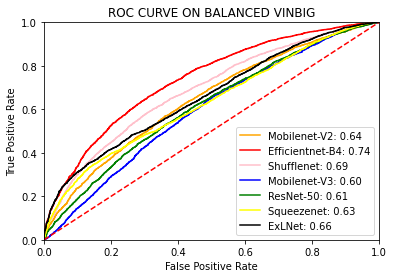

In [75]:
preds = pred_mobv2[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_mobv2, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Mobilenet-V2: %0.2f' % roc_auc,color = 'orange')

preds = pred_effb4[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_effb4, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Efficientnet-B4: %0.2f' % roc_auc,color = 'red')

preds = pred_shuff[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_shuff, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Shufflenet: %0.2f' % roc_auc,color = 'pink')

preds = pred_mobv3[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_mobv3, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Mobilenet-V3: %0.2f' % roc_auc,color = 'blue')

preds = pred_res50[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_res50, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'ResNet-50: %0.2f' % roc_auc,color = 'green')

preds = pred_squeeze[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Squeezenet: %0.2f' % roc_auc,color = 'yellow')

preds = pred_exlnet[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_exlnet, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'ExLNet: %0.2f' % roc_auc,color = 'black')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC CURVE ON BALANCED VINBIG')
plt.savefig('vinbig_balanced_ROC.png')
plt.savefig('vinbig_balanced_ROC.svg',format = 'svg')
plt.show()